In [54]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# 读取 perf script 输出文件并返回内容
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.readlines()

# 统计函数调用次数
def count_function_calls(lines):
    function_counter = Counter()
    num=0
    for line in lines:
        match = re.search(r'L[^+]*', line)
        if match:
            num+=1
            func_name = match.group(0)
            function_counter[func_name] += 1
    print(num)
    return function_counter

# 提取函数调用时间
def extract_function_times(lines):
    function_times = []
    for line in lines:
        match = re.search(r'(\d+):(\d+)\s+cpu-clock', line)
        if match:
            timestamp = float(match.group(1)) + float(match.group(2)) / 1e6
            function_times.append(timestamp)
    return function_times

# 生成函数调用次数的报告和图表
def display_function_call_report(counter):
    for func, count in counter.most_common():
        print(f'{func}: {count}')
    
    functions, counts = zip(*counter.most_common(10))  # 只取前10个函数
    plt.figure(figsize=(10, 6))
    plt.barh(functions[::-1], counts[::-1])
    plt.xlabel('Call Count')
    plt.ylabel('Function')
    plt.title('Top 10 Most Called Functions')
    plt.tight_layout()
    plt.show()

# 生成函数调用时间的报告
def display_function_time_report(times):
    for time in times:
        print(f'{time}')

# 主函数
def main(path):
    lines = read_file(path)
    function_counter = count_function_calls(lines)

    print(len(function_counter))
    print('函数调用次数报告和图表')
    display_function_call_report(function_counter)
    


In [55]:
# main('out-7570.collapsed')

673092
153
函数调用次数报告和图表
Ljava/io/ObjectInputStream;::readObject0: 99946
Ljava/io/ObjectInputStream;::readOrdinaryObject: 81372
Ljava/io/ObjectInputStream;::readSerialData: 66532
Ljava/io/ObjectInputStream;::defaultReadFields: 56689
Ljava/io/ObjectOutputStream;::writeObject0: 47060
Lspec/benchmarks/serial/Main;::serialize: 43181
Ljava/io/ObjectOutputStream;::writeOrdinaryObject: 35769
Ljava/io/ObjectOutputStream;::writeSerialData: 33706
Ljava/io/ObjectInputStream;::readObject: 30788
Ljava/io/ObjectOutputStream;::defaultWriteFields: 28452
Ljava/io/ObjectInputStream;::readClassDesc: 14907
Lspec/benchmarks/serial/Main;::harnessMain: 12422
Lspec/harness/BenchmarkThread;::runLoop: 12422
Lsun/reflect/DelegatingMethodAccessorImpl;::invoke: 11682
Ljava/io/ObjectInputStream$BlockDataInputStream;::readUTFBody: 9012
Ljava/io/ObjectInputStream;::readArray: 8597
Ljava/lang/reflect/Method;::invoke: 6028
Ljava/io/ObjectInputStream$BlockDataInputStream;::readUTFSpan: 5950
Ljava/io/ObjectStreamClass;::re

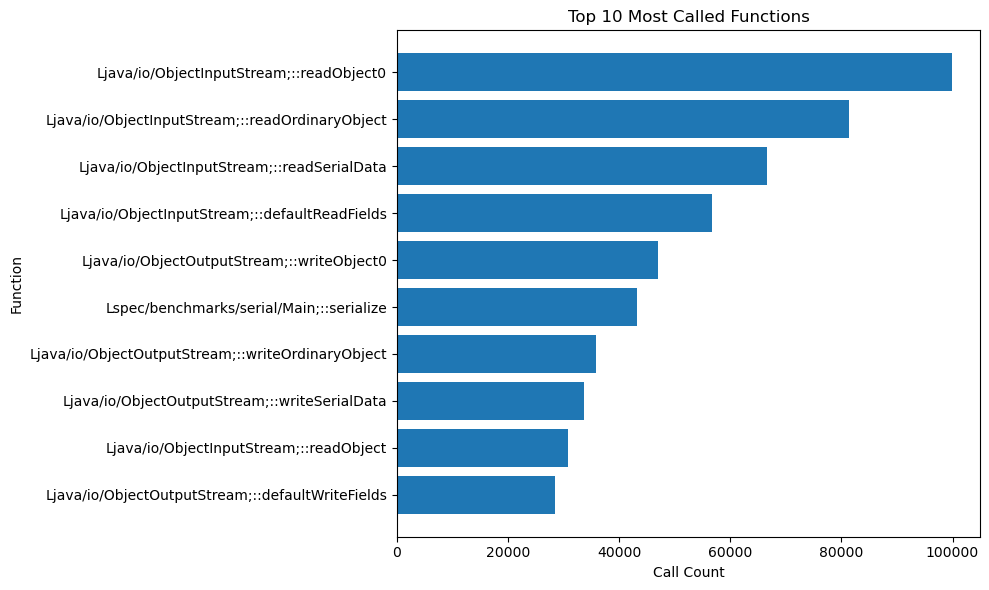

In [56]:
main('out-7570.stacks')

In [57]:
import pandas as pd
import re

# 从文件中读取记录的函数
def parse_perf_records(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    thread_name = ''
    pid = ''
    timestamp = ''
    
    for line in lines:
        if line.startswith('BenchmarkThread'):
            parts = line.split()
            thread_name = parts[0]
            pid = parts[1]
            timestamp = parts[2].replace(':', '')
        else:
            match = re.search(r'L[^+]*', line)
            if match:
                function_name = match.group(0)
                data.append([thread_name, function_name, pid, timestamp])
    
    df = pd.DataFrame(data, columns=['Thread', 'Function', 'PID', 'Timestamp'])
    return df


file_path = 'out-7570.stacks'
df = parse_perf_records(file_path)
print(df)


                 Thread                                         Function  \
0       BenchmarkThread  Ljava/io/ObjectInputStream;::readOrdinaryObject   
1       BenchmarkThread         Ljava/io/ObjectInputStream;::readObject0   
2       BenchmarkThread   Ljava/io/ObjectInputStream;::defaultReadFields   
3       BenchmarkThread      Ljava/io/ObjectInputStream;::readSerialData   
4       BenchmarkThread  Ljava/io/ObjectInputStream;::readOrdinaryObject   
...                 ...                                              ...   
673087  BenchmarkThread         Ljava/io/ObjectInputStream;::readObject0   
673088  BenchmarkThread          Ljava/io/ObjectInputStream;::readObject   
673089  BenchmarkThread         Lspec/benchmarks/serial/Main;::serialize   
673090  BenchmarkThread       Lspec/benchmarks/serial/Main;::harnessMain   
673091  BenchmarkThread          Lspec/harness/BenchmarkThread;::runLoop   

         PID    Timestamp  
0       7584  2625.758470  
1       7584  2625.758470  
2  

In [80]:
function_timestamp_dict = {}
for index, row in df.iterrows():
    function = row['Function']
    timestamp = row['Timestamp']
    if function not in function_timestamp_dict:
        function_timestamp_dict[function] = []
    function_timestamp_dict[function].append(timestamp)
    
print(len(function_timestamp_dict))

153


In [82]:
execution_time_dict = {}
for function, timestamps in function_timestamp_dict.items():
    sorted_timestamps = sorted(map(float, timestamps))
    execution_time = sorted_timestamps[-1] - sorted_timestamps[0]
    execution_time_dict[function] = execution_time
top_10_functions = sorted(execution_time_dict.items(), key=lambda x: x[1], reverse=True)[:-1]
functions, execution_times = zip(*top_10_functions)
total_execution_time = sum(execution_times)
average_execution_time = total_execution_time / len(execution_times)

print(f"Total Execution Time: {total_execution_time:.6f} seconds")
print(f"Average Execution Time: {average_execution_time:.6f} seconds")
# plt.figure(figsize=(12, 8))
# plt.barh(functions, execution_times, color='skyblue')
# plt.xlabel('Execution Time (seconds)')
# # plt.title('Functions with Longest Execution Time')
# plt.gca().invert_yaxis()  # 反转 Y 轴，使得执行时间最长的函数在最上面
# plt.show()


Total Execution Time: 25682.087294 seconds
Average Execution Time: 168.961101 seconds


In [87]:
precision = 0  # 保留的小数位数，可以调整为 0, 1, 2 等
rounded_function_timestamp_dict = {
    function: sorted(set(round(float(ts), precision) for ts in timestamps))
    for function, timestamps in function_timestamp_dict.items()
}
# 输出舍入并去重后的字典
print("Rounded and deduplicated function_timestamp_dict:")
print(rounded_function_timestamp_dict)

Rounded and deduplicated function_timestamp_dict:
{'Ljava/io/ObjectInputStream;::readOrdinaryObject': [2626.0, 2627.0, 2628.0, 2629.0, 2630.0, 2631.0, 2632.0, 2633.0, 2634.0, 2635.0, 2636.0, 2637.0, 2638.0, 2639.0, 2640.0, 2641.0, 2642.0, 2643.0, 2644.0, 2645.0, 2646.0, 2647.0, 2648.0, 2649.0, 2650.0, 2651.0, 2652.0, 2653.0, 2654.0, 2655.0, 2656.0, 2657.0, 2658.0, 2659.0, 2660.0, 2661.0, 2662.0, 2663.0, 2664.0, 2665.0, 2666.0, 2667.0, 2668.0, 2669.0, 2670.0, 2671.0, 2672.0, 2673.0, 2674.0, 2675.0, 2676.0, 2677.0, 2678.0, 2679.0, 2680.0, 2681.0, 2682.0, 2683.0, 2684.0, 2685.0, 2686.0, 2687.0, 2688.0, 2689.0, 2690.0, 2691.0, 2692.0, 2693.0, 2694.0, 2695.0, 2696.0, 2697.0, 2698.0, 2699.0, 2700.0, 2701.0, 2702.0, 2703.0, 2704.0, 2705.0, 2706.0, 2707.0, 2708.0, 2709.0, 2710.0, 2711.0, 2712.0, 2713.0, 2714.0, 2715.0, 2716.0, 2717.0, 2718.0, 2719.0, 2720.0, 2721.0, 2722.0, 2723.0, 2724.0, 2725.0, 2726.0, 2727.0, 2728.0, 2729.0, 2730.0, 2731.0, 2732.0, 2733.0, 2734.0, 2735.0, 2736.0, 2737.0, 2

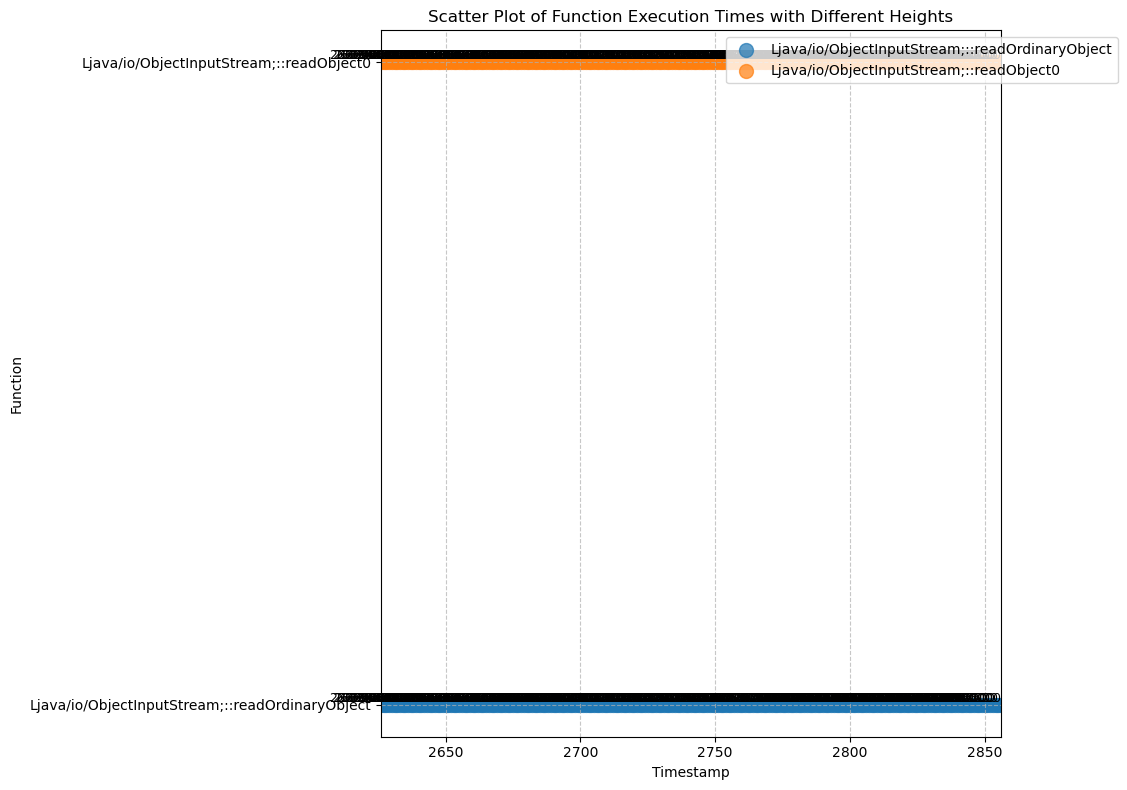

In [91]:
# 创建一个新的图形和坐标轴
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制散点图
for i, (function, timestamps) in enumerate(rounded_function_timestamp_dict.items()):
    height = i  # 确保每个函数的散点图在不同的高度上
    ax.scatter(timestamps, [height] * len(timestamps), label=function, s=100, alpha=0.7)  # 绘制散点图
    # 添加文本注释
    for ts in timestamps:
        ax.text(ts, height, f'{ts:.2f}', ha='right', va='bottom', fontsize=9)

# 设置图形的X轴和Y轴标签
ax.set_xlabel('Timestamp')
ax.set_ylabel('Function')
ax.set_title('Scatter Plot of Function Execution Times with Different Heights')

# 设置X轴范围
start_time = min(ts for timestamps in rounded_function_timestamp_dict.values() for ts in timestamps)
end_time = max(ts for timestamps in rounded_function_timestamp_dict.values() for ts in timestamps)
ax.set_xlim(start_time, end_time)

# 设置Y轴范围
ax.set_yticks(range(len(rounded_function_timestamp_dict)))
ax.set_yticklabels(rounded_function_timestamp_dict.keys())

# 添加图例
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

# 展示图形
plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

def pltCpu(paths):
    plt.figure(figsize=(12, 6))  # 创建一个新的绘图窗口
    for i,data_file in enumerate(paths):
        # 读取数据文件
        data = []
        now=0
        with open(data_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            
            for line in lines:
                if line.strip() and not line.startswith('# Time'):  # 跳过空行和头部行
                    parts = line.split()
                    if len(parts) >= 18:  # 检查行是否具有至少18列
                        try:
                            time_str = parts[0] + ' ' + parts[1]
                            cpu_total = float(parts[8])
                            # 计算从日志开始时间起经过的秒数
                            elapsed_time = now
                            now+=5
                            data.append([elapsed_time, cpu_total])
                        except ValueError:
                            # 跳过无效行
                            print(f"Skipping invalid line: {line.strip()}")
                    else:
                        # 跳过列数不匹配的行
                        print(f"Skipping line with unexpected number of columns: {line.strip()}")
        
        # 将数据转换为 DataFrame
        columns = ['ElapsedTime', '%CPU']
        df = pd.DataFrame(data, columns=columns)
        
        # df = df.sort_values(by='ElapsedTime')
        
        # 选择不同颜色和标签来区分不同的日志文件
        color = plt.cm.viridis(i / len(paths))  # 使用 colormap 生成不同颜色
        label = f'Log {i + 1}'  # 标签可以是 Log 1, Log 2 等
        label = paths[i]
        # 绘制 CPU 占用图
        plt.plot(df['ElapsedTime'], df['%CPU'], label=label, color=color)
    
    # 按时间排序

    
    # 添加标签和标题
    plt.xlabel('Elapsed Time (seconds)')
    plt.ylabel('CPU Usage (%)')
    plt.title('CPU Usage Over Time from Multiple Logs')
    plt.legend()
    plt.grid(True)
    
    # 设置 x 轴刻度为每 30 秒一个刻度
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: str(int(x)) + 's'))  # x 轴标签格式为秒数
    
    plt.tight_layout()
    plt.show()




Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)


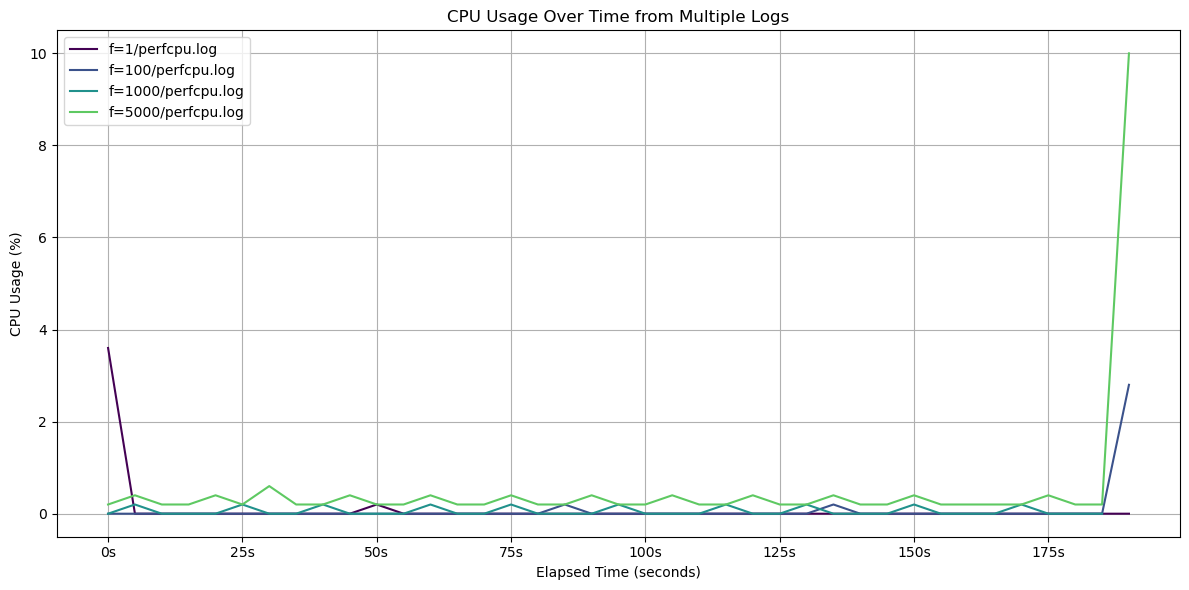

In [2]:
paths = ['f=1/perfcpu.log',
        'f=100/perfcpu.log',
         'f=1000/perfcpu.log',
         'f=5000/perfcpu.log'
         ] 
pltCpu(paths)

Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)
Skipping line with unexpected number of columns: Linux 5.15.0-106-generic (iZf8zetnft7hz64q6zlvzzZ) 	07/14/2024 	_x86_64_	(2 CPU)


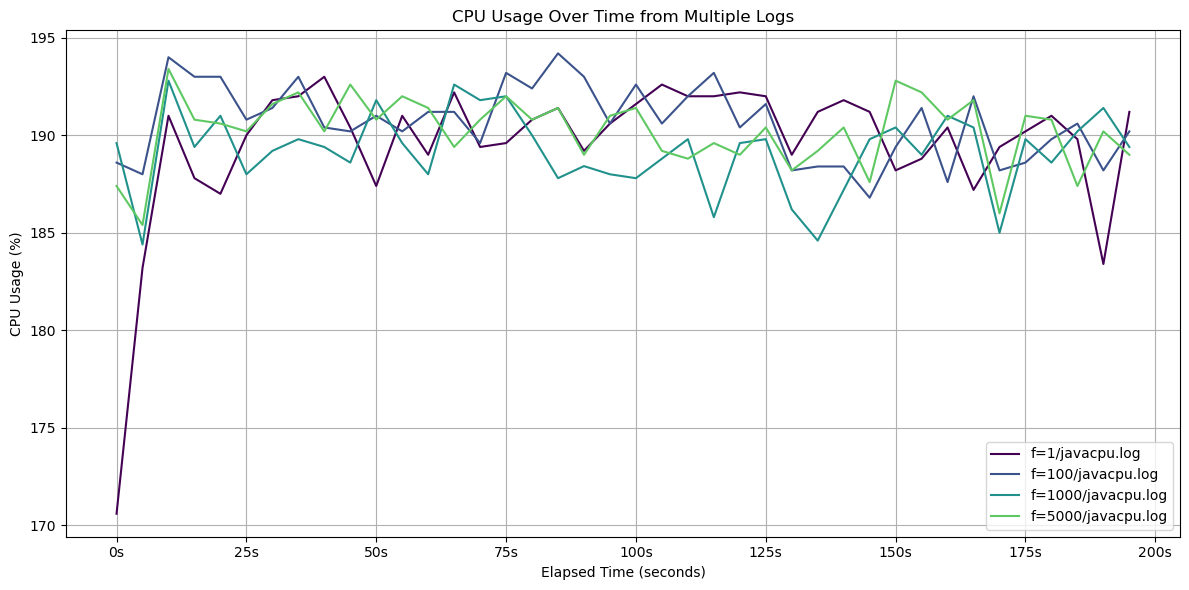

In [3]:
paths = ['f=1/javacpu.log',
        'f=100/javacpu.log',
         'f=1000/javacpu.log',
         'f=5000/javacpu.log'
         ] 
pltCpu(paths)